In [50]:
"""
Micah Holness
10/13/2024
CSC 8850
"""
import numpy as np
import torch
import scipy.io.wavfile as sw
import scipy.signal as ss
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd
import os

In [32]:
# import .wav data & labels
img_root = "/Users/mholness1/Desktop/CSC 8850 Project/techcabal-ewe-audio-translation-challenge20240903-4068-o1ckqz/TechCabal Ewe Audio Files-20241014T013956Z-002/TechCabal Ewe Audio Files/"
csv_data = pd.read_csv('./Train.csv', sep=',')
print(csv_data.keys())
images = csv_data['audio_filepath']
labels = csv_data['class']

unique_labels = np.unique(labels)
print(unique_labels)
labels_class = np.arange(0,len(np.unique(labels)))
print(labels_class)

# create class to load data into DataLoader (and preprocess)
freq_spectrum = []
freq_labels = []
for widx, wv in enumerate(images):
    fpath = os.path.join(img_root, wv)
    if os.path.isfile(fpath) == 1:
        fs, data = sw.read(fpath)
        class_tmp = labels[widx]
        cidx = np.where(class_tmp == unique_labels)[0]
        freq_labels.append(cidx)
        # convert time domain to frequency domain
        if len(data.shape) > 1:
            data = data[:,0]
        # transforming the 1-D time-series into a frequency spectrum
        fft = np.fft.fft(data)
        fft_centered = np.fft.fftshift(fft)
        fft_magn = np.log10(np.abs(fft_centered)**2)
        # print(fft_magn.shape)
        fft_magn_dwn = ss.resample(fft_magn, 51744, axis=0).astype(np.float32)
        freq_spectrum.append(fft_magn_dwn.T)

freq_spectrum_arr = np.stack(freq_spectrum, axis=0)
freq_labels_arr = np.array(freq_labels)

imgs_length = [freq.shape[0] for freq in freq_spectrum_arr]
print(np.min(imgs_length))      # 51744

np.save('training_data.npy', freq_spectrum_arr)
np.save('training_labels.npy', freq_labels_arr)

Index(['id', 'audio_filepath', 'duration', 'class'], dtype='object')
['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']
[0 1 2 3 4 5 6 7]


KeyboardInterrupt: 

(799, 51744)
Shapiro-Wilk Statistic: 0.9793568268865794
P-value: 3.401083772496944e-09
0.0 1.0


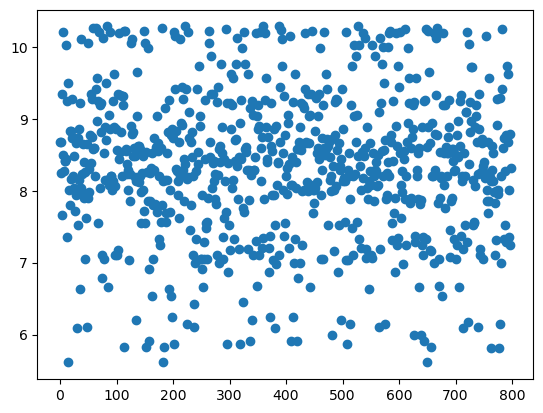

In [51]:
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import scipy.stats as stat

# load the training data arrays
training_data = np.load('./training_data.npy', allow_pickle=True)
training_labels = np.load('./training_labels.npy', allow_pickle=True)

print(training_data.shape)      # 799, 51744

# visualize data (means)
fig = plt.figure()
plt.scatter(np.arange(0,training_data.shape[0]), np.mean(training_data, axis=1))

# Perform the Shapiro-Wilk test ---> test for normality
statistic, p_value = stat.shapiro(np.mean(training_data, axis=1))
print("Shapiro-Wilk Statistic:", statistic)
print("P-value:", p_value)

# note: according to Shapiro-Wilk test, data is significantly skewed
# thus, when data is non-normal/non-Gaussian, normalization is preferred [for unknown distribution]
# normalize data range = 0 -> 1
training_data = (training_data - np.min(training_data)) / (np.max(training_data) - np.min(training_data))
print(np.min(training_data), np.max(training_data))

# one-hot encode labels
training_labels_tmp = torch.tensor(training_labels.flatten())
training_labels = nn.functional.one_hot(training_labels_tmp)

class MyDataset(Dataset):
    def __init__(self):
        self.imgs = training_data
        self.labels = training_labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.imgs[idx]
        label = self.labels[idx]
        return image, label

dataset = MyDataset()
dataloader_train = DataLoader(dataset,
                              batch_size=64,
                              shuffle=True,
                              num_workers=0,
                              pin_memory=False)

print(dataloader_train)

In [80]:
import torch.nn as nn
import torch.optim as optim

# Define your CNN model
class MyCNN(nn.Module):
    def __init__(self, n_classes):
        super(MyCNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3),
            nn.Conv1d(in_channels=32, out_channels=75, kernel_size=3),
            nn.MaxPool1d(kernel_size = 2, stride = 2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels=75, out_channels=100, kernel_size=3),
            nn.Conv1d(in_channels=100, out_channels=75, kernel_size=3),
            nn.Conv1d(in_channels=75, out_channels=32, kernel_size=3),
            nn.Conv1d(in_channels=32, out_channels=1, kernel_size=3),
            nn.MaxPool1d(kernel_size = 2, stride = 2),
            nn.AdaptiveAvgPool1d(100)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(100, 225),
            nn.ReLU(),
            nn.Linear(225, 475),
            nn.ReLU(),
            nn.Linear(475, 210),
            nn.ReLU(),
            nn.Linear(210, 100),
            nn.ReLU(),
            nn.Linear(100, 25),
            nn.ReLU(),
            nn.Linear(25, n_classes)
        )     

    def forward(self, x):
        x = torch.unsqueeze(x, axis=0)
        x = torch.permute(x, (1,0,2))
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.fc_layers(x)
        return x
    
# set weight initialization
def init_weights(model):
    """Set Conv weights to be He initialization (Kaiming uniform distr) for all Convs
        bound = gain x sqrt(3 / fan_mode), 
        where final tensor has bounds (-bound, +bound) from a uniform distri.
        gain (multiplicative factor adjusting weights prior to feeding into neurons), that
        has influence on the weight magnitudes, by preserving weight magnitudes in backwards pass (fan_out: n = number of inputs to node)
        **** He = recommended for use with ReLU ****
    
        Linear layer weights are truncated normal distribution
        mean = 0, std = 1, with all values within bounds a <= u <= b
    """
    for m in model.modules():
        if isinstance(m, (nn.Conv1d)):
            nn.init.kaiming_uniform_(m.weight, mode='fan_out', nonlinearity='relu') 
            nn.init.constant_(m.bias, 0.0)
        if isinstance(m, (nn.Linear)):
            nn.init.trunc_normal_(m.weight, mean=0.0, std=1.0, a=-2.0, b=2.0, generator=None)
    
model = MyCNN(n_classes=7)
print(model.eval())

MyCNN(
  (conv1): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,))
    (1): Conv1d(32, 75, kernel_size=(3,), stride=(1,))
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv1d(75, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(100, 75, kernel_size=(3,), stride=(1,))
    (2): Conv1d(75, 32, kernel_size=(3,), stride=(1,))
    (3): Conv1d(32, 1, kernel_size=(3,), stride=(1,))
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): AdaptiveAvgPool1d(output_size=100)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=100, out_features=225, bias=True)
    (1): ReLU()
    (2): Linear(in_features=225, out_features=475, bias=True)
    (3): ReLU()
    (4): Linear(in_features=475, out_features=210, bias=True)
    (5): ReLU()
    (6): Linear(in_features=210, out_features=100, bias=True)
    (7): ReLU()
    (8): Linear(in_features=100, out_features=25, bias=Tru

In [84]:
for didx, data in enumerate(dataloader_train):
    print(type(data))
    img, label = data
    print(img, label)

<class 'list'>
tensor([[0.3752, 0.3994, 0.3925,  ..., 0.3994, 0.3925, 0.3994],
        [0.2981, 0.3143, 0.3160,  ..., 0.3089, 0.3160, 0.3143],
        [0.2880, 0.2348, 0.2537,  ..., 0.2313, 0.2537, 0.2348],
        ...,
        [0.4806, 0.4843, 0.4864,  ..., 0.4846, 0.4864, 0.4843],
        [0.3287, 0.3244, 0.3550,  ..., 0.3114, 0.3550, 0.3244],
        [0.3452, 0.3016, 0.3199,  ..., 0.3368, 0.3199, 0.3016]]) tensor([[0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0],
        [0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0]

In [86]:
# Instantiate model, loss, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)

# Training loop
epochs = 100
for epoch in range(epochs):
    for i, data in enumerate(dataloader_train):
        inputs, labels = data

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        outputs = torch.squeeze(outputs)
        outputs = outputs.float()
        labels = labels.float()
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # assess accuracy
        softmax_func = nn.Softmax(dim=1)
        softmax = softmax_func(outputs)
        acc_vector = torch.stack([(torch.argmax(softmax[iidx])==torch.argmax(labels[iidx])) for iidx in np.arange(0,labels.shape[0])], dim=0).flatten()
        accuracy = torch.sum(acc_vector) / labels.shape[0]

        # Print progress
        print(f"Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(dataloader_train)}], \
              Loss: {loss.item():.4f}, Accuracy: {accuracy}")


Epoch [1/100], Step [1/13],               Loss: 1.9220, Accuracy: 0.203125
Epoch [1/100], Step [2/13],               Loss: 1.9370, Accuracy: 0.171875
Epoch [1/100], Step [3/13],               Loss: 1.8519, Accuracy: 0.34375
Epoch [1/100], Step [4/13],               Loss: 1.6672, Accuracy: 0.46875
Epoch [1/100], Step [5/13],               Loss: 2.1497, Accuracy: 0.296875
Epoch [1/100], Step [6/13],               Loss: 2.1328, Accuracy: 0.125
Epoch [1/100], Step [7/13],               Loss: 1.8380, Accuracy: 0.328125
Epoch [1/100], Step [8/13],               Loss: 1.8808, Accuracy: 0.203125
Epoch [1/100], Step [9/13],               Loss: 1.9196, Accuracy: 0.265625
Epoch [1/100], Step [10/13],               Loss: 1.9029, Accuracy: 0.25
Epoch [1/100], Step [11/13],               Loss: 1.9317, Accuracy: 0.125
Epoch [1/100], Step [12/13],               Loss: 1.9136, Accuracy: 0.1875
Epoch [1/100], Step [13/13],               Loss: 1.9099, Accuracy: 0.19354838132858276
Epoch [2/100], Step [1/1